## CNN Architecture

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

#CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

#VIS
from keras.utils.vis_utils import plot_model

In [2]:
def _prepareData(path): 
    '''
    parameters: path(STR) of the directory and flag(INT) to know if we prepare data of training or testing
    return: (LIST) of images of the dataset and the (LIST) of labels
    
    For training:
    -Read images of every directory and extract all images
    -Resize to (128,128,3)
    -Read the directory name and asign as a class
    '''
    imgsList = []
    labels = []
    for directory in sorted(glob.glob(os.path.join(path, '*')), key = lambda k: k.split("/")[-1]):
            for imgs in glob.glob(os.path.join(directory,'*.jpg')):
                img_cv = cv2.imread(imgs)
                img_cv_r = cv2.resize(img_cv,(128,128))
                imgsList.append(img_cv_r)
                labels.append(int(directory.split("/")[-1].replace('c','')))
    
    X_Train, X_Test, Y_Train, Y_Test =  train_test_split(imgsList,labels, test_size = 0.2)
    Y_Train = tf.keras.utils.to_categorical(Y_Train, num_classes=10)
    Y_Test = tf.keras.utils.to_categorical(Y_Test, num_classes=10)

    return np.array(X_Train), np.array(X_Test), Y_Train, Y_Test

In [3]:
#Paths
pathTrain_Images = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train/"
pathPropagate_Images =  "/kaggle/input/state-farm-distracted-driver-detection/imgs/test/"

#List of Images for Train and Test
X_Train, X_Test, Y_Train, Y_Test = _prepareData(pathTrain_Images)

print("Size X_Train: {}, Size Y_Train: {}".format(len(X_Train),len(Y_Train)))
print("Size X_Test: {}, Size Y_Test: {}".format(len(X_Test),len(Y_Test)))

Size X_Train: 17939, Size Y_Train: 17939
Size X_Test: 4485, Size Y_Test: 4485


17939
(128, 128, 3)


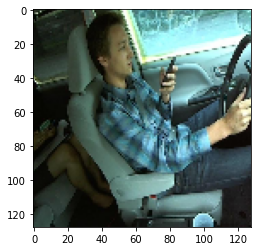

Class: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [4]:
print(len(X_Train))
print(X_Train[202].shape)
im = X_Train[202]
RGB_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_im)
plt.show()
print("Class: {}".format(Y_Train[202]))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

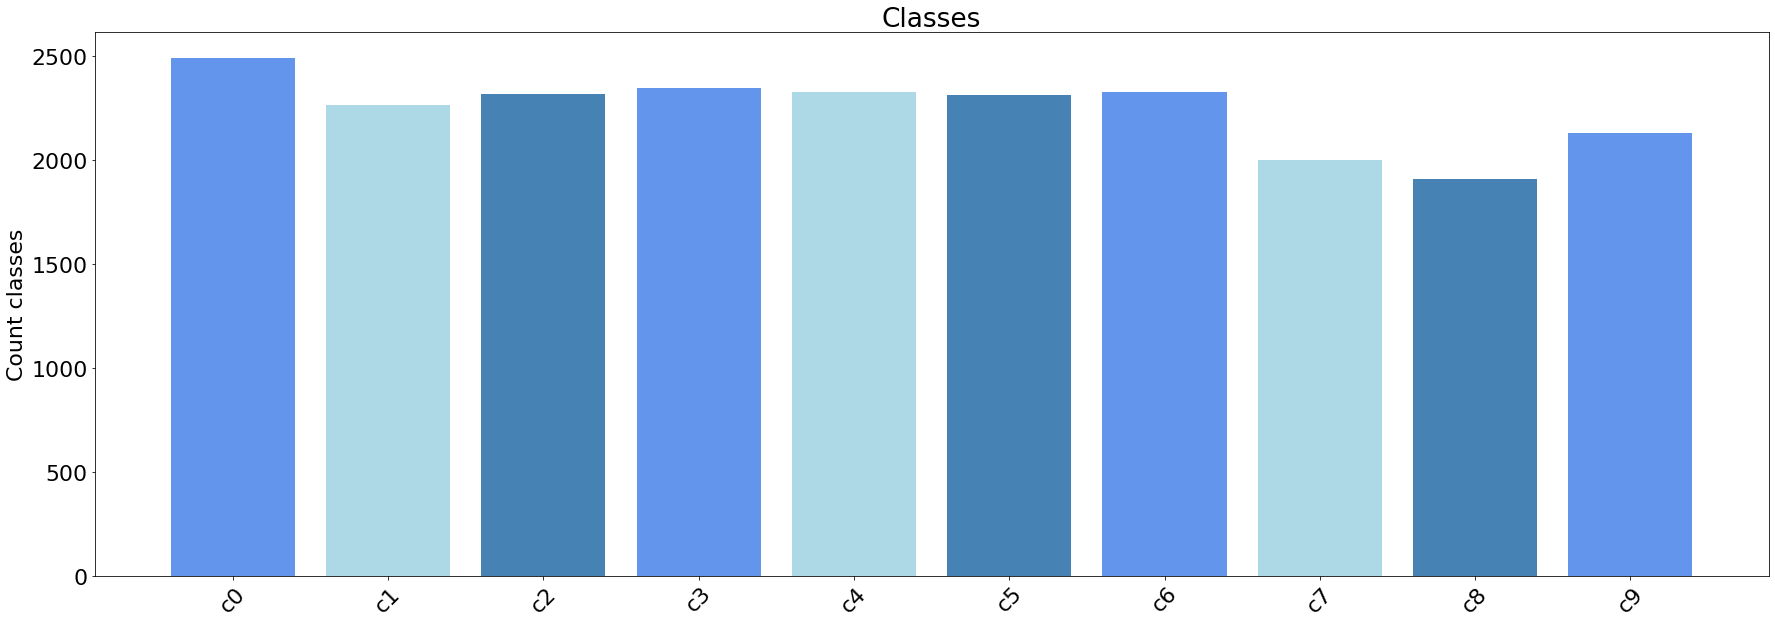

In [5]:
data_file = pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv")
data_classes = data_file.loc[:,['classname','img']].groupby(by='classname').count().reset_index()

data_x = list(pd.unique(data_file['classname']))
data_y =list(data_classes['img'])

# Parámetros de ploteo (Se va a generar un plot diferente para cada Clase)
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,10))
plt.bar(data_x, data_y, color=['cornflowerblue', 'lightblue', 'steelblue'])  
plt.ylabel('Count classes')
plt.title('Classes')
plt.xticks(rotation=45)

In [7]:
model = keras.models.Sequential()

model.add(keras.layers.InputLayer(
    input_shape=(128, 128, 3)
))

model.add(
    keras.layers.Conv2D(
        filters=32,
        kernel_size=(5,5),
        strides = (1,1),
        padding='same',
        activation='relu',
        name='Conv_1'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_1'))#Image_size: 32*64*64(32 filters,image_size 64*64)

model.add(
    keras.layers.Conv2D(
        filters = 64,
        kernel_size = (5,5),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_2'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_2'))#Image_size: 64*32*32(64 filters,image_size 32*32)

model.add(
    keras.layers.Conv2D(
        filters = 128,
        kernel_size = (5,5),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_3'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_3'))#Image_size: 128*16*16(128 filters,image_size 16*16)

model.add(
    keras.layers.Conv2D(
        filters = 256,
        kernel_size = (5,5),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_4'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_4'))#Image_size: 256*8*8(256 filters,image_size 8*8)

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=1024, activation='relu',name = 'fc_1'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=512, activation='relu',name = 'fc_2'))
model.add(keras.layers.Dense(units=10,activation='softmax',name = 'fc_3'))

model.save('/tmp/model')
#model.save('../input/result1')
#model.compute_output_shape(input_shape=(256,8,8,1))

In [8]:
tf.random.set_seed(1)
#model.build(input_shape=(None,128,128,3))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False), metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 64, 64, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 64, 64, 64)        51264     
_________________________________________________________________
Pool_2 (MaxPooling2D)        (None, 32, 32, 64)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 32, 32, 128)       204928    
_________________________________________________________________
Pool_3 (MaxPooling2D)        (None, 16, 16, 128)       0         
_________________________________________________________________
Conv_4 (Conv2D)              (None, 16, 16, 256)      

In [9]:
history = model.fit(x = X_Train, y=Y_Train,epochs =18, batch_size = 500, verbose = 1, validation_split=0.2)

Epoch 1/18
29/29 [==============================] - 89s 3s/step - loss: 39.8181 - accuracy: 0.1336 - val_loss: 1.5930 - val_accuracy: 0.4261
Epoch 2/18
29/29 [==============================] - 64s 2s/step - loss: 1.3023 - accuracy: 0.5403 - val_loss: 0.6852 - val_accuracy: 0.7765
Epoch 3/18
29/29 [==============================] - 64s 2s/step - loss: 0.4994 - accuracy: 0.8421 - val_loss: 0.2294 - val_accuracy: 0.9328
Epoch 4/18
29/29 [==============================] - 64s 2s/step - loss: 0.1653 - accuracy: 0.9514 - val_loss: 0.1306 - val_accuracy: 0.9635
Epoch 5/18
29/29 [==============================] - 64s 2s/step - loss: 0.0809 - accuracy: 0.9766 - val_loss: 0.0961 - val_accuracy: 0.9746
Epoch 6/18
29/29 [==============================] - 64s 2s/step - loss: 0.0546 - accuracy: 0.9852 - val_loss: 0.0763 - val_accuracy: 0.9822
Epoch 7/18
29/29 [==============================] - 64s 2s/step - loss: 0.0360 - accuracy: 0.9892 - val_loss: 0.0867 - val_accuracy: 0.9808
Epoch 8/18
29/29 [=

In [10]:
test_loss, test_acc = model.evaluate(X_Test, Y_Test, verbose = 1)

141/141 [==============================] - 17s 114ms/step - loss: 0.0842 - accuracy: 0.9826


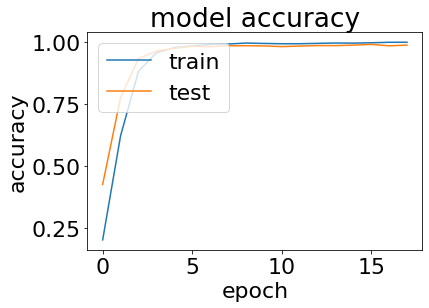

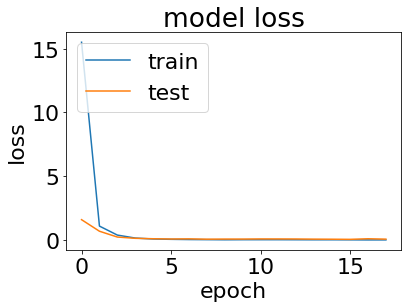

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.ylim([0.9,1])
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.ylim([0,.4])
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights('./Train_weights_1.h5', overwrite = True)

In [12]:
model.save('./new_model.h5')

In [ ]:
model.load_weights('./Train_weights_1.h5')

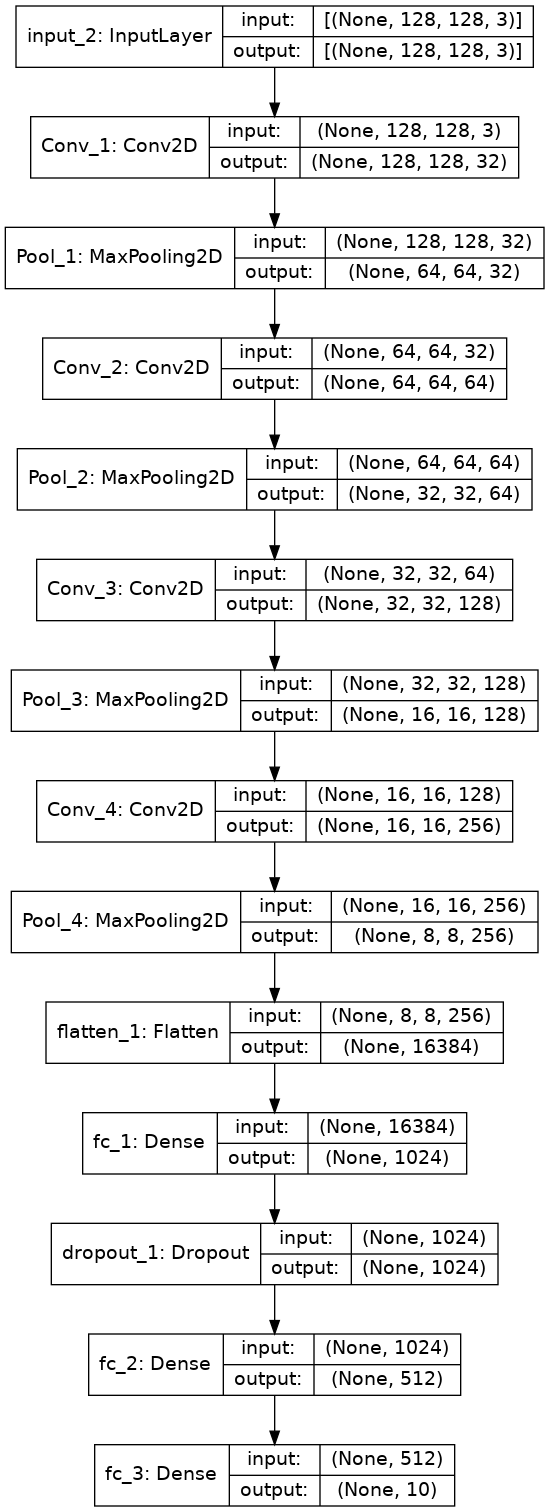

In [13]:
keras.utils.plot_model(model,"model.png",show_shapes = True)

Image number: 0
Image number: 1
Image number: 2
Image number: 3
Image number: 4
Image number: 5
Image number: 6
Image number: 7
Image number: 8
Image number: 9
Image number: 10
Image number: 11
Image number: 12
Image number: 13
Image number: 14
Image number: 15
Image number: 16
Image number: 17
Image number: 18
Image number: 19


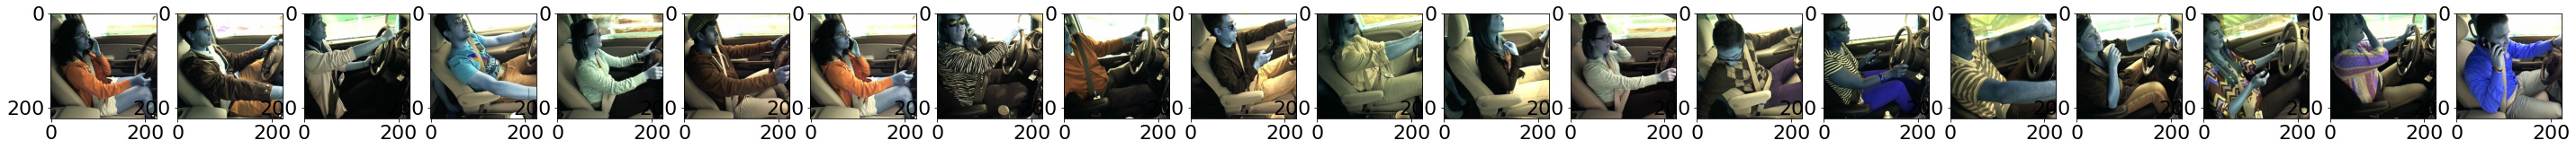

In [14]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

test_image = []
i = 0
fig, ax = plt.subplots(1, 20, figsize = (50,50 ))

files = os.listdir('../input/state-farm-distracted-driver-detection/imgs/test/')
nums = np.random.randint(low=1, high=len(files), size=20)
for i in range(20):
    print ('Image number:',i)
    img = cv2.imread('../input/state-farm-distracted-driver-detection/imgs/test/'+files[nums[i]])
    #img = color.rgb2gray(img)
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    test_image.append(img)
    ax[i].imshow(img,cmap = 'gray')
    plt.show